## Data wrangling with spark

In [2]:
import findspark
findspark.init('/home/nikhil/spark-2.4.4-bin-hadoop2.7')

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType,IntegerType
from pyspark.sql.functions import desc,asc, sum as Fsum

import datetime
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
spark=SparkSession.builder.appName('datawranglinb').getOrCreate()

In [5]:
user_log=spark.read.json('data/sparkify_log_small.json')

### data exploration


In [6]:
user_log.head(5)

[Row(artist='Showaddywaddy', auth='Logged In', firstName='Kenneth', gender='M', itemInSession=112, lastName='Matthews', length=232.93342, level='paid', location='Charlotte-Concord-Gastonia, NC-SC', method='PUT', page='NextSong', registration=1509380319284, sessionId=5132, song='Christmas Tears Will Fall', status=200, ts=1513720872284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='1046'),
 Row(artist='Lily Allen', auth='Logged In', firstName='Elizabeth', gender='F', itemInSession=7, lastName='Chase', length=195.23873, level='free', location='Shreveport-Bossier City, LA', method='PUT', page='NextSong', registration=1512718541284, sessionId=5027, song='Cheryl Tweedy', status=200, ts=1513720878284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='1000'),
 Row(artist='Cobra Starship Featuring Leighton Meester', auth='Logged In', firstNa

In [7]:
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [8]:
user_log.describe("artist").show()

+-------+-----------------+
|summary|           artist|
+-------+-----------------+
|  count|             8347|
|   mean|            461.0|
| stddev|            300.0|
|    min|              !!!|
|    max|ÃÂlafur Arnalds|
+-------+-----------------+



In [11]:
user_log.count()

10000

#### To drop the duplicate

In [12]:
user_log.select("page").dropDuplicates().sort('page').show()

+----------------+
|            page|
+----------------+
|           About|
|       Downgrade|
|           Error|
|            Help|
|            Home|
|           Login|
|          Logout|
|        NextSong|
|   Save Settings|
|        Settings|
|Submit Downgrade|
|  Submit Upgrade|
|         Upgrade|
+----------------+



###  To see if duplicate contais are not

In [13]:
if user_log.count()>user_log.dropDuplicates(['page']).count():
    raise ValueError('data has duplicate')

ValueError: data has duplicate

### To see what songs a user listened to 

In [15]:
user_log.select(['userId','firstname','page','song']).where(user_log['userId']=='1046').collect()

[Row(userId='1046', firstname='Kenneth', page='NextSong', song='Christmas Tears Will Fall'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Be Wary Of A Woman'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Public Enemy No.1'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Reign Of The Tyrants'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Father And Son'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='No. 5'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Seventeen'),
 Row(userId='1046', firstname='Kenneth', page='Home', song=None),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='War on war'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Killermont Street'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Black & Blue'),
 Row(userId='1046', firstname='Kenneth', page='Logout', song=None),
 Row(userId='1046', firstname='Kenneth'

### Calculating Statistics by hour

In [16]:
get_hour=udf(lambda x:datetime.datetime.fromtimestamp(x/1000.0).hour)

In [17]:
user_log=user_log.withColumn('hour',get_hour(user_log.ts))

In [25]:
user_log.head()

Row(artist='Showaddywaddy', auth='Logged In', firstName='Kenneth', gender='M', itemInSession=112, lastName='Matthews', length=232.93342, level='paid', location='Charlotte-Concord-Gastonia, NC-SC', method='PUT', page='NextSong', registration=1509380319284, sessionId=5132, song='Christmas Tears Will Fall', status=200, ts=1513720872284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='1046', hour='23')

In [29]:
songs_in_hour= user_log.filter(user_log.page=='NextSong').groupby(user_log.hour).count()

In [30]:
songs_in_hour.orderBy(songs_in_hour.hour.cast("float")).show()

+----+-----+
|hour|count|
+----+-----+
|   0|  375|
|   1|  456|
|   2|  454|
|   3|  382|
|   4|  302|
|   5|  352|
|   6|  276|
|   7|  348|
|   8|  358|
|   9|  375|
|  10|  249|
|  11|  216|
|  12|  228|
|  13|  251|
|  14|  339|
|  15|  462|
|  16|  479|
|  17|  484|
|  18|  430|
|  19|  362|
+----+-----+
only showing top 20 rows



In [31]:
user_log.filter(user_log.page=='NextSong').groupby(user_log.hour).count().show()

+----+-----+
|hour|count|
+----+-----+
|   7|  348|
|  15|  462|
|  11|  216|
|   3|  382|
|   8|  358|
|  22|  248|
|  16|  479|
|   0|  375|
|   5|  352|
|  18|  430|
|  17|  484|
|   6|  276|
|  19|  362|
|  23|  369|
|   9|  375|
|   1|  456|
|  20|  295|
|  10|  249|
|   4|  302|
|  12|  228|
+----+-----+
only showing top 20 rows



In [32]:
songs_in_hour_pd=songs_in_hour.toPandas()

In [34]:
songs_in_hour_pd.hour=pd.to_numeric(songs_in_hour_pd.hour)

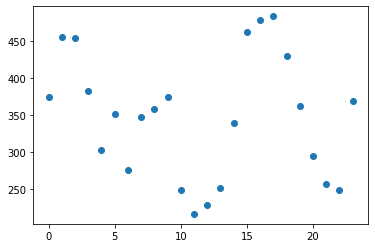

In [35]:
plt.scatter(songs_in_hour_pd['hour'],songs_in_hour_pd['count'])

## Drop the rows which are missing

In [36]:
user_log_valid=user_log.dropna(how='any',subset=['userID','sessionId'])

In [37]:
user_log_valid.count()

10000

In [41]:
user_log_valid=user_log.filter(user_log['userId']!='')

In [42]:
user_log_valid.count()

9664

## Data manipulation

In [43]:
user_log_valid.filter('page= "Submit Downgrade"').show()

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|            page| registration|sessionId|song|status|           ts|           userAgent|userId|hour|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+
|  null|Logged In|    Kelly|     F|           24|  Newton|  null| paid|Houston-The Woodl...|   PUT|Submit Downgrade|1513283366284|     5931|null|   307|1513768454284|Mozilla/5.0 (Wind...|  1138|  12|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+


In [45]:
user_log.select(['userId','firstname','page','level','song']).where(user_log.userId=="1138").collect()

[Row(userId='1138', firstname='Kelly', page='Home', level='paid', song=None),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Everybody Everybody'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Gears'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Use Somebody'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Love Of My Life (1993 Digital Remaster)'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Down In The Valley Woe'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Treat Her Like A Lady'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song="Everybody Thinks You're An Angel"),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Fourteen Wives'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Love On The Rocks'),
 Row(userId='1138', f

In [46]:
flag_downgrade=udf(lambda x: 1 if x=="Submit Downgrade" else 0,IntegerType())

In [47]:
user_log_valid=user_log_valid.withColumn("downgrade",flag_downgrade("page"))

In [48]:
user_log_valid.head()

Row(artist='Showaddywaddy', auth='Logged In', firstName='Kenneth', gender='M', itemInSession=112, lastName='Matthews', length=232.93342, level='paid', location='Charlotte-Concord-Gastonia, NC-SC', method='PUT', page='NextSong', registration=1509380319284, sessionId=5132, song='Christmas Tears Will Fall', status=200, ts=1513720872284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='1046', hour='23', downgrade=0)

In [49]:
from pyspark.sql import Window

In [50]:
windowval=Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding,0)

In [52]:
user_log_valid=user_log_valid.withColumn("phase",Fsum("downgraded").over(windowval))

AnalysisException: "cannot resolve '`downgraded`' given input columns: [itemInSession, hour, lastName, auth, sessionId, firstName, userId, location, gender, status, level, artist, downgrade, ts, userAgent, page, length, registration, song, method];;\n'Project [artist#6, auth#7, firstName#8, gender#9, itemInSession#10L, lastName#11, length#12, level#13, location#14, method#15, page#16, registration#17L, sessionId#18L, song#19, status#20L, ts#21L, userAgent#22, userId#23, hour#240, downgrade#678, sum('downgraded) windowspecdefinition(userId#23, ts#21L DESC NULLS LAST, specifiedwindowframe(RangeFrame, unboundedpreceding$(), currentrow$())) AS phase#722]\n+- Project [artist#6, auth#7, firstName#8, gender#9, itemInSession#10L, lastName#11, length#12, level#13, location#14, method#15, page#16, registration#17L, sessionId#18L, song#19, status#20L, ts#21L, userAgent#22, userId#23, hour#240, <lambda>(page#16) AS downgrade#678]\n   +- Filter NOT (userId#23 = )\n      +- Project [artist#6, auth#7, firstName#8, gender#9, itemInSession#10L, lastName#11, length#12, level#13, location#14, method#15, page#16, registration#17L, sessionId#18L, song#19, status#20L, ts#21L, userAgent#22, userId#23, <lambda>(ts#21L) AS hour#240]\n         +- Relation[artist#6,auth#7,firstName#8,gender#9,itemInSession#10L,lastName#11,length#12,level#13,location#14,method#15,page#16,registration#17L,sessionId#18L,song#19,status#20L,ts#21L,userAgent#22,userId#23] json\n"